In [1]:
import numpy as np
import os

def load_registered_sample(base_directory,registered_directory,start,end):
    corrected_svt = np.load(os.path.join(base_directory, "Corrected_SVT.npy"))
    u = np.load(os.path.join(registered_directory, "Registered_U.npy"))
    delta_f_sample = np.dot(u, corrected_svt[:, start:end])
    return delta_f_sample

def normalize_periodograms(S):
    #try to normalize each signal dividing by its maximum
    max_values = np.max(S, axis=1)
    # divide each row by its maximum value
    S = S / max_values.reshape(-1, 1)
    return S   

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal,stats
import os

import sys
sys.path.append('../utils')
sys.path.append('../dFC')
import widefield_utils
import connectivity_measures

In [3]:
Ts = 0.036
sample_start = 0
sample_end = 1000
std_error = 1/np.sqrt(6)

I do it with registered data and I average in every area 

In [4]:
names_wild = ["NXAK22.1A","NXAK14.1A","NXAK7.1B","NXAK4.1B","NRXN78.1D","NRXN78.1A"]
names_knock = ["NXAK24.1C","NXAK20.1B","NXAK16.1B","NXAK10.1A","NXAK4.1A","NRXN71.2A"]

atlas_dict = np.load(r"/home/k21208334/calcium_analyses/data/Atlas_Region_Dict_Registered.npy", allow_pickle=True)[()]
pixel_labels = atlas_dict["pixel_labels"]

In [5]:
# load the data in dictionaries
signals_dict = {}

for name in names_wild+names_knock:
    base_directory = r"/home/k21208334/calcium_analyses/data/" + name + "/"
    registered_directory = r"/home/k21208334/calcium_analyses/data/registration_data/" + name + "/"
    signals = load_registered_sample(base_directory,registered_directory,sample_start,sample_end)
    signals_dict.update({name: signals})


In [6]:
# note be careful with PSD normalizations...dunno if I did it right! REmember to do both Welsh and normal avg
# do only for running/ not running 

#signals_dict = np.load('signals_8k.npy.npz')

/tmp/ipykernel_923957/4023987291.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1,2)
/tmp/ipykernel_923957/4023987291.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1,2)


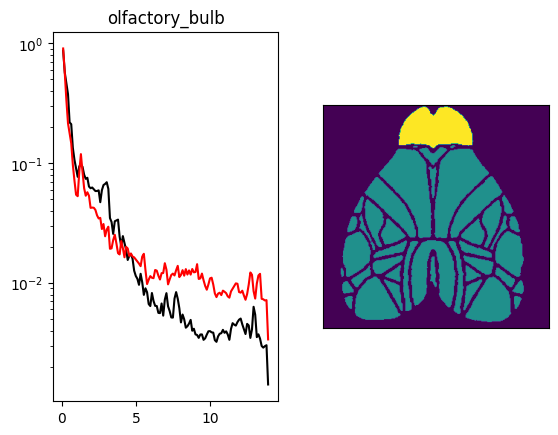

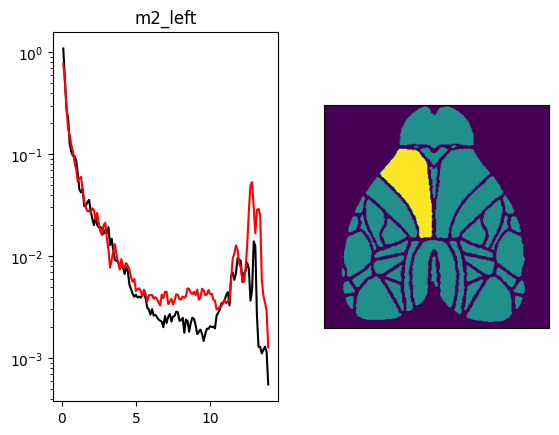

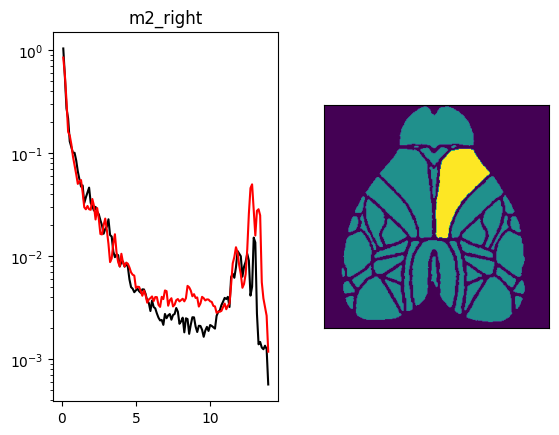

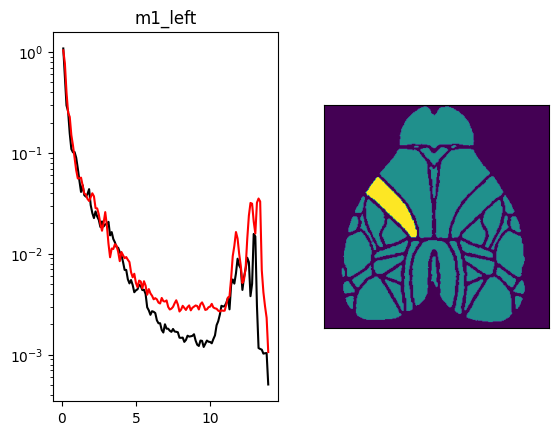

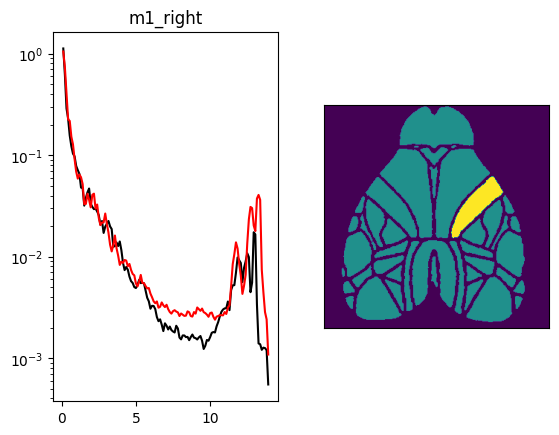

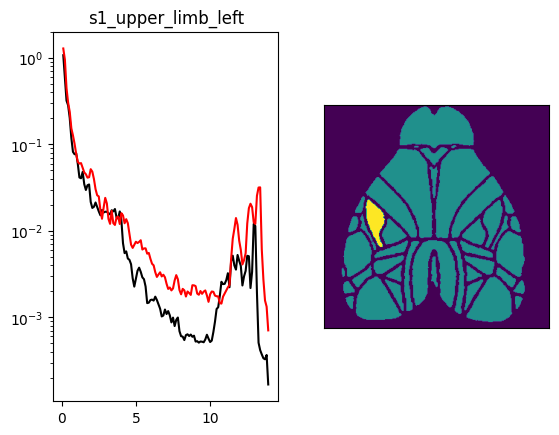

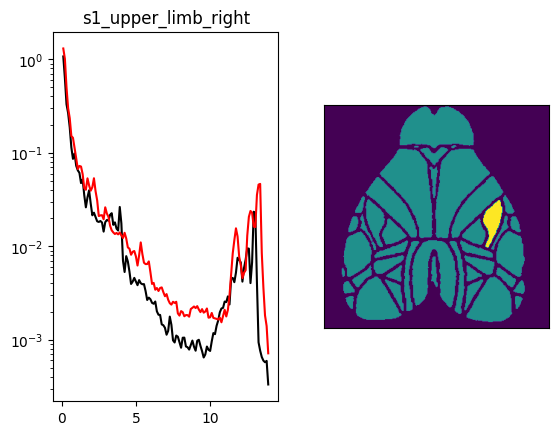

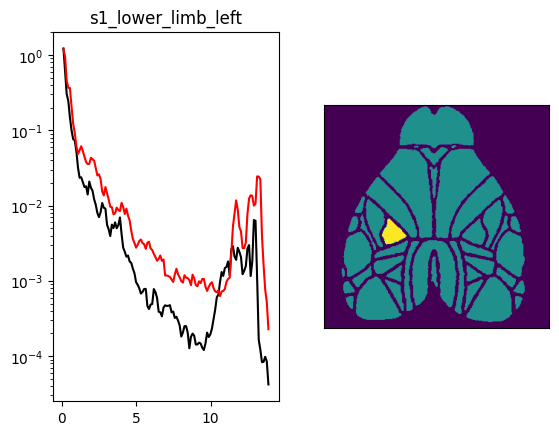

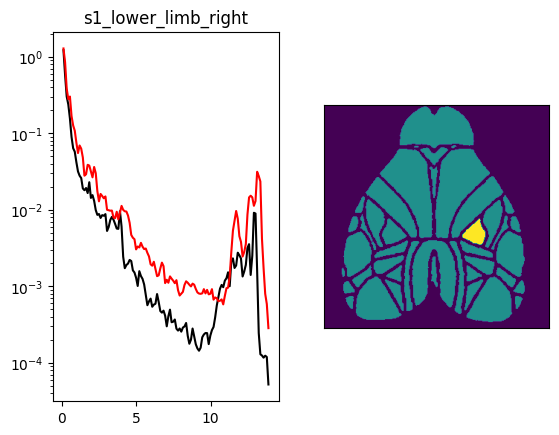

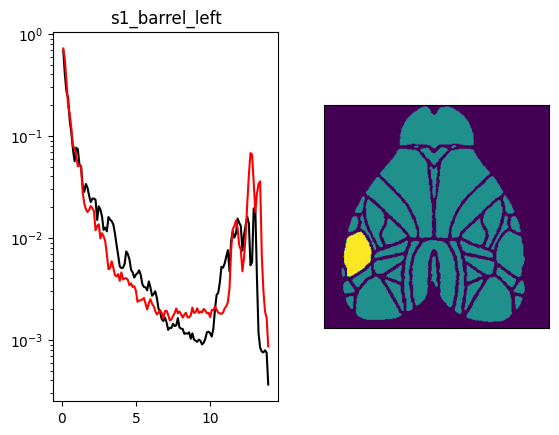

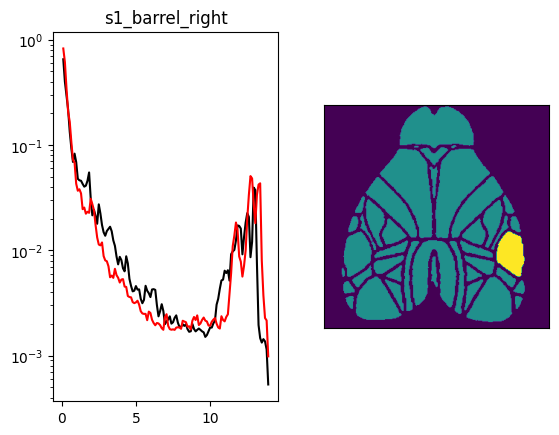

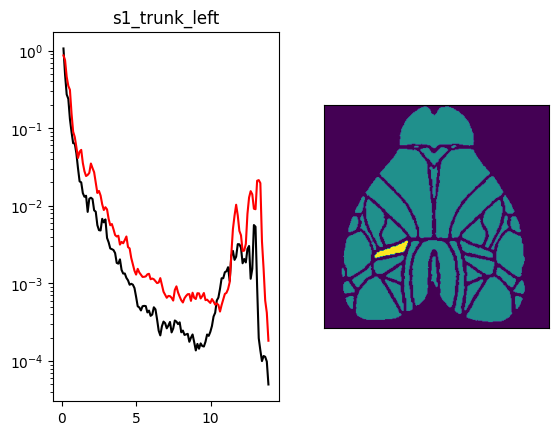

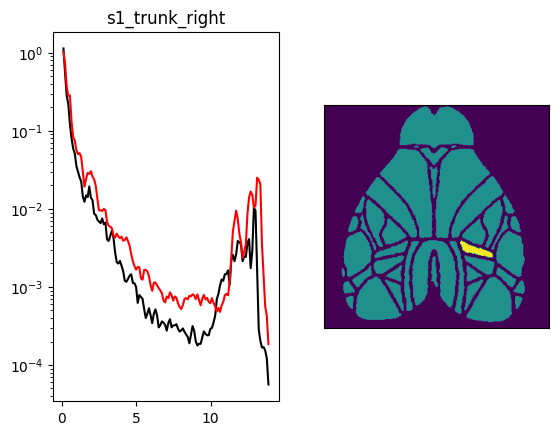

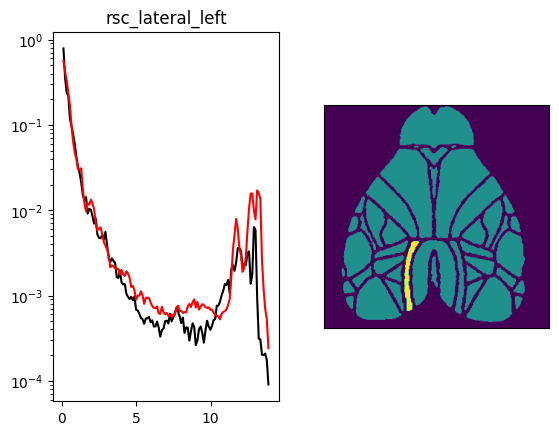

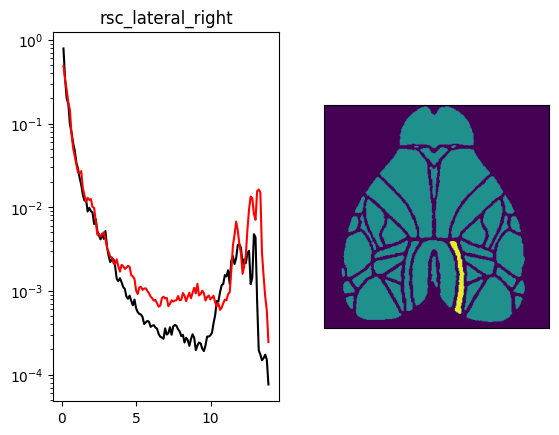

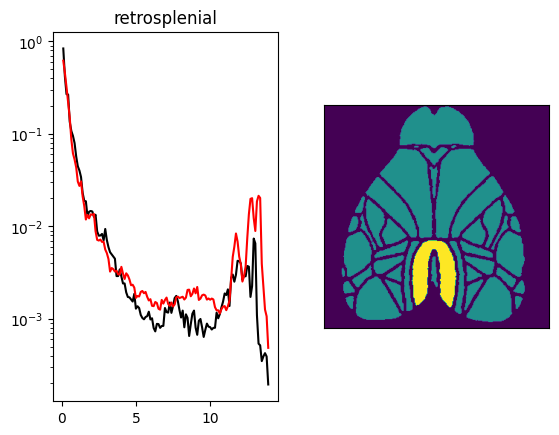

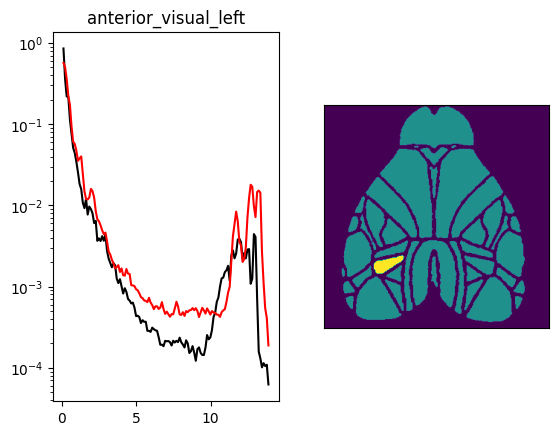

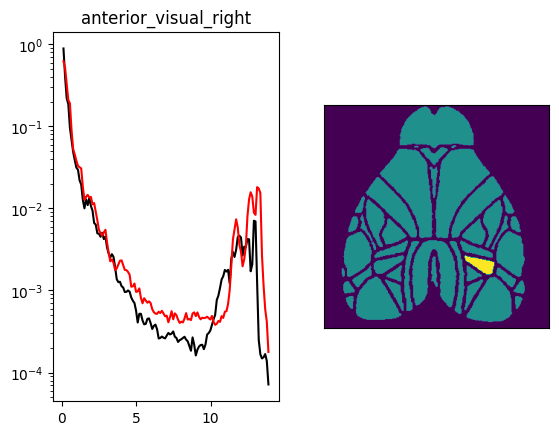

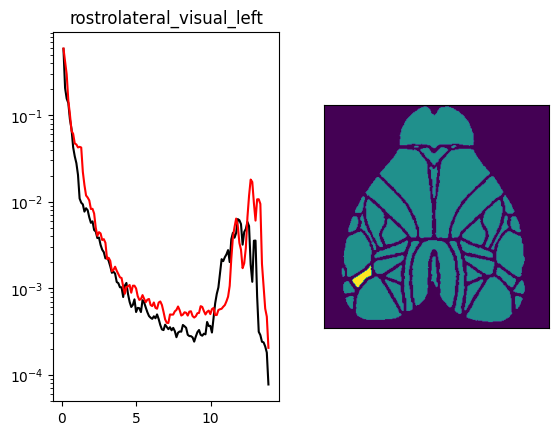

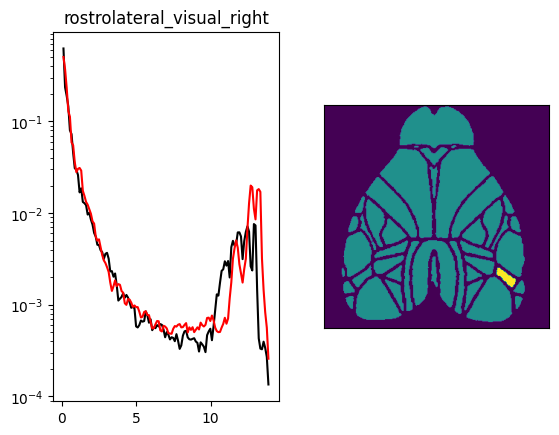

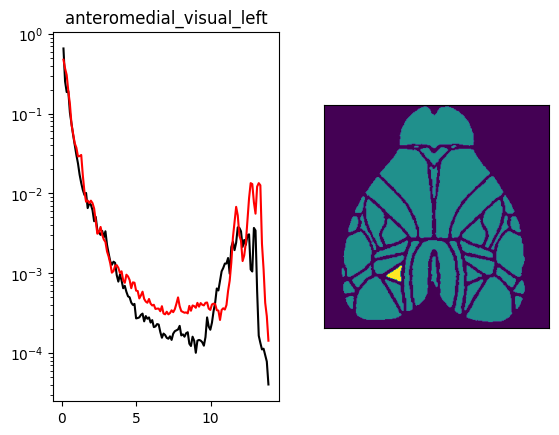

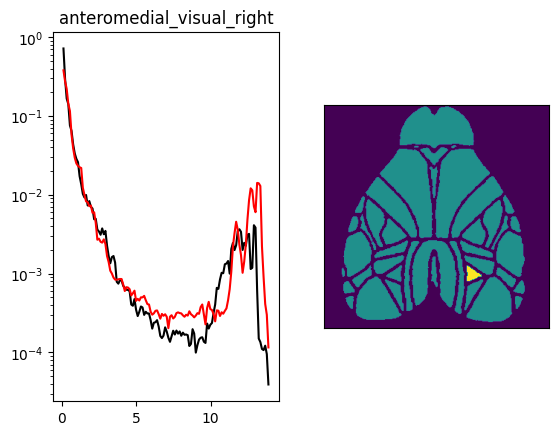

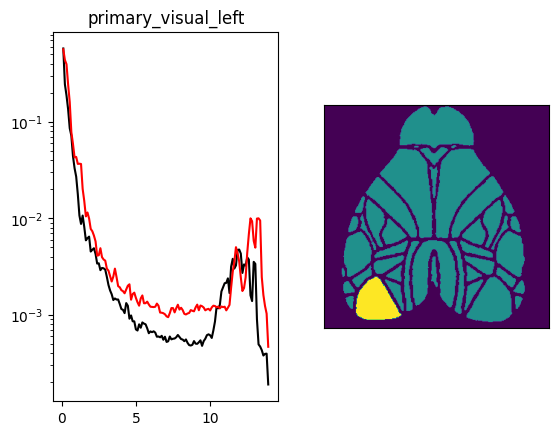

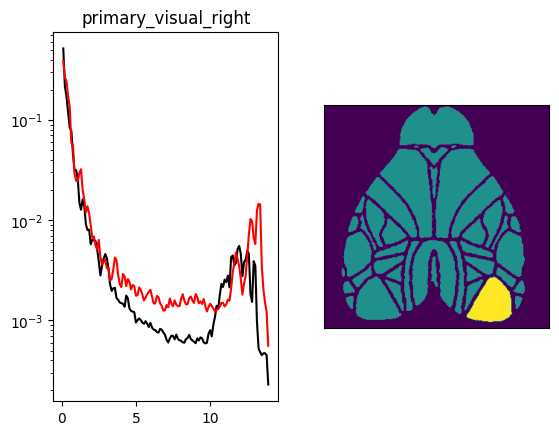

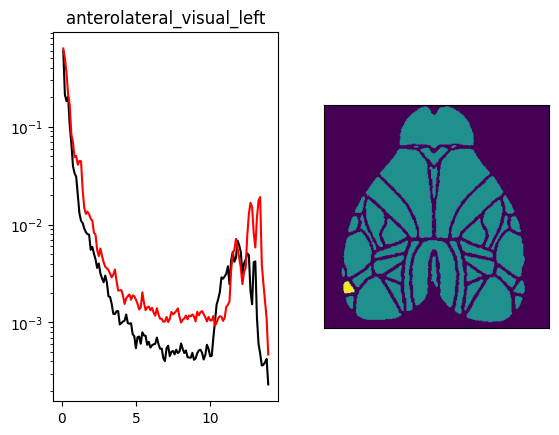

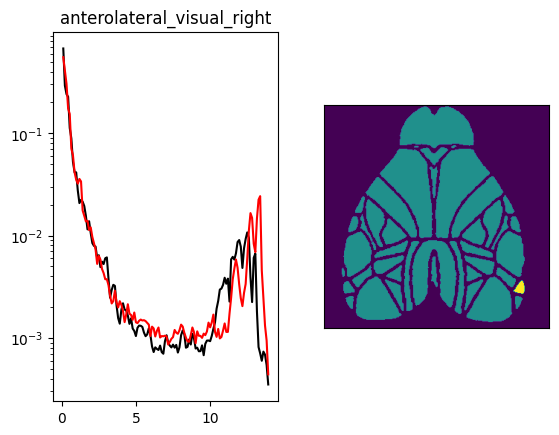

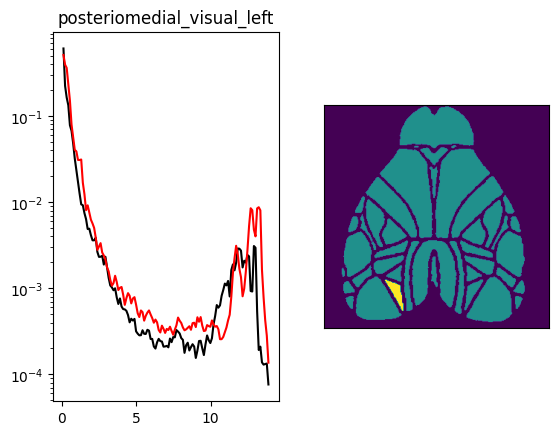

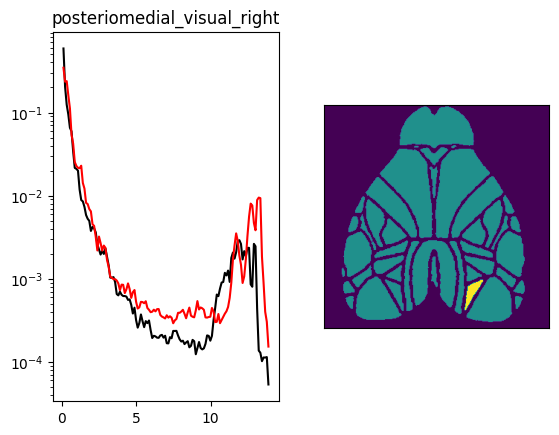

In [11]:
from scipy.stats import mannwhitneyu

for region in list(atlas_dict.keys())[1:]:
 
    spectra_wild = []
    spectra_knock = []
    
    for name in names_wild+names_knock:
        
        signals = signals_dict[name]
        region_indices = np.where(pixel_labels == atlas_dict[region])
        region_signals = signals[region_indices]
        # another way of normalization is to do z score. It's an alternative to calling the fcn "normalize_periodogram"
        # i think this approach is more clearn because it should normalize the power
        region_signals = stats.zscore(region_signals,axis=1)
        (f, S) = signal.welch(region_signals, 1/Ts, scaling='density') # you can also try signal.periodogram
        #S = normalize_periodogram(S); # this is an alternative to zscoring. To discuss
        if name in names_wild:
            spectra_wild.append(S)
        else:
            spectra_knock.append(S)
            
    distr_spectra_wild = np.empty((0, np.shape(spectra_wild)[2]))
                                
    for spectra in spectra_wild[:]:                      
        distr_spectra_wild = np.append(distr_spectra_wild,spectra,axis=0)
                                
    avg_spectra_wild = np.mean(distr_spectra_wild,axis=0)
    std_spectra_wild = np.std(distr_spectra_wild,axis=0)                            
        
    distr_spectra_knock = np.empty((0, np.shape(spectra_knock)[2]))
                                
    for spectra in spectra_knock[:]:                      
        distr_spectra_knock = np.append(distr_spectra_knock,spectra,axis=0)
                                
    avg_spectra_knock = np.mean(distr_spectra_knock,axis=0)
    std_spectra_knock = np.std(distr_spectra_knock,axis=0)   
    
    
    # compute p values
    p_values = []
    for i in range(distr_spectra_knock.shape[1]):
        u_statistic, p_value = mannwhitneyu(distr_spectra_wild[:, i], distr_spectra_knock[:, i])
        p_values.append(p_value)
    p_values = np.array(p_values)
    test = p_values/129<0.05   # ii do a stupid bonferroni correction
    

    fig,ax = plt.subplots(1,2)
    ax[0].semilogy(f[1:],avg_spectra_wild[1:],color="black")
    ax[0].semilogy(f[1:],avg_spectra_wild[1:]+std_error*std_spectra_wild[1:],'--',color="black")
    ax[0].semilogy(f[1:],avg_spectra_wild[1:]-std_error*std_spectra_wild[1:],'--',color="black")
    ax[0].semilogy(f[1:],avg_spectra_knock[1:],color="red")
    ax[0].semilogy(f[1:],avg_spectra_knock[1:]+std_error*std_spectra_knock[1:],'--',color="red")
    ax[0].semilogy(f[1:],avg_spectra_knock[1:]-std_error*std_spectra_knock[1:],'--',color="red")
    
    ax[0].semilogy(f[1:],1*test[1:],color="blue")
    
    ax[0].set_title(region)
    
    region_mask = np.where(pixel_labels == atlas_dict[region], 1, 0)
    ax[1].imshow(1*(pixel_labels>1)+region_mask)
    ax[1].set_xticks([])
    ax[1].set_xticklabels([])
    ax[1].set_yticks([])
    ax[1].set_yticklabels([])
    
    fig.savefig(region+'errorbars.png')   # save the figure to file
    plt.close(fig) 
    
    fig,ax = plt.subplots(1,2)
    ax[0].semilogy(f[1:],avg_spectra_wild[1:],color="black")
    ax[0].semilogy(f[1:],avg_spectra_knock[1:],color="red")
    ax[0].set_title(region)
    
    region_mask = np.where(pixel_labels == atlas_dict[region], 1, 0)
    ax[1].imshow(1*(pixel_labels>1)+region_mask)
    ax[1].set_xticks([])
    ax[1].set_xticklabels([])
    ax[1].set_yticks([])
    ax[1].set_yticklabels([])
    
    #fig.savefig(region+'.png')   # save the figure to file
    #plt.close(fig) 
                      

In [ ]:
# this is the old code...

In [9]:
f.shape

(129,)

SVT Shape (200, 25498)
U Shape (300, 304, 200)
Delta F Sample (300, 304, 12000)
SVT Shape (500, 25537)
U Shape (300, 304, 500)
Delta F Sample (300, 304, 12000)
SVT Shape (500, 25651)
U Shape (300, 304, 500)
Delta F Sample (300, 304, 12000)
SVT Shape (500, 25699)
U Shape (300, 304, 500)
Delta F Sample (300, 304, 12000)
SVT Shape (500, 25607)
U Shape (300, 304, 500)
Delta F Sample (300, 304, 12000)
SVT Shape (500, 25382)
U Shape (300, 304, 500)
Delta F Sample (300, 304, 12000)
SVT Shape (500, 25527)
U Shape (300, 304, 500)
Delta F Sample (300, 304, 12000)
SVT Shape (500, 25833)
U Shape (300, 304, 500)
Delta F Sample (300, 304, 12000)
SVT Shape (500, 25441)
U Shape (300, 304, 500)
Delta F Sample (300, 304, 12000)
SVT Shape (500, 25554)
U Shape (300, 304, 500)
Delta F Sample (300, 304, 12000)
SVT Shape (500, 25567)
U Shape (300, 304, 500)
Delta F Sample (300, 304, 12000)
SVT Shape (500, 25390)
U Shape (300, 304, 500)
Delta F Sample (300, 304, 12000)


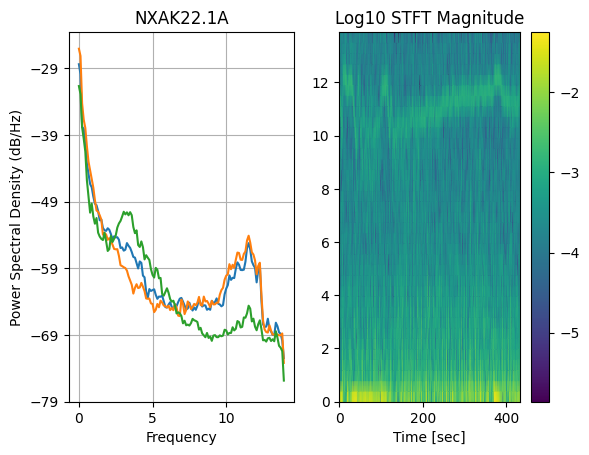

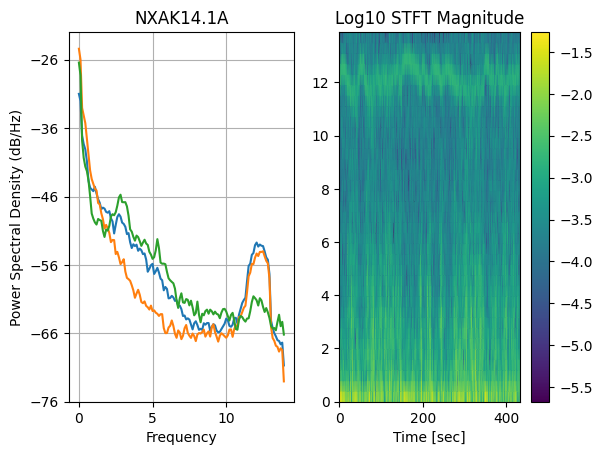

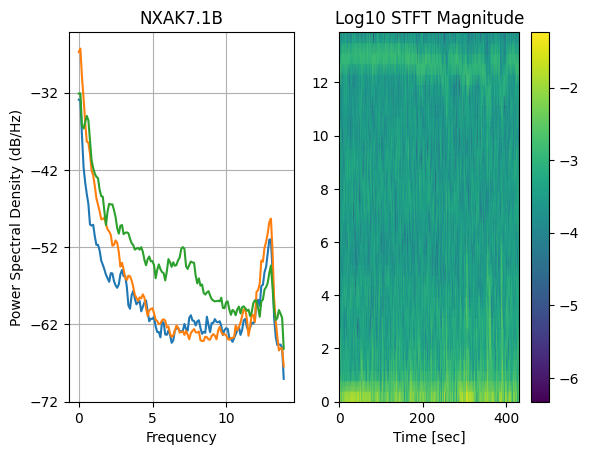

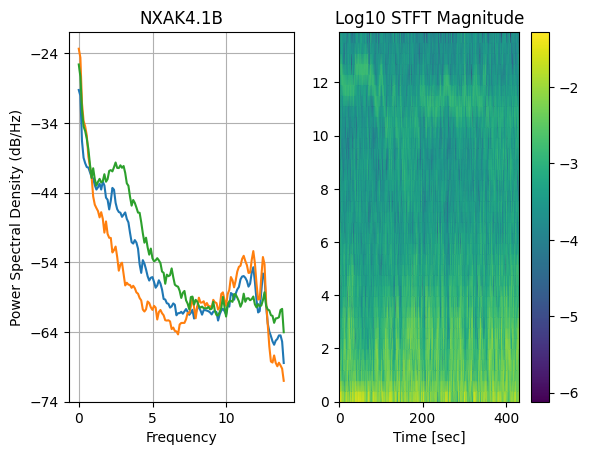

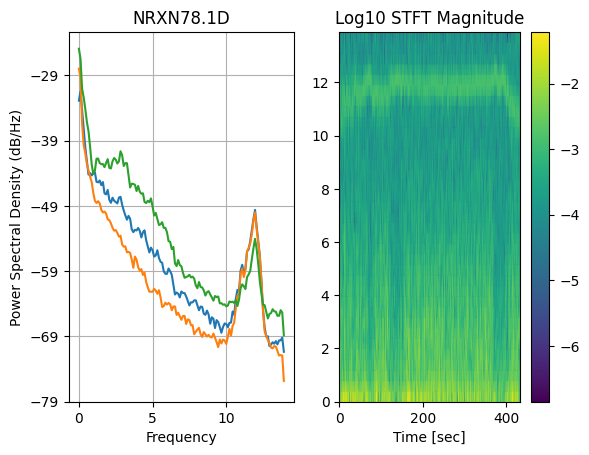

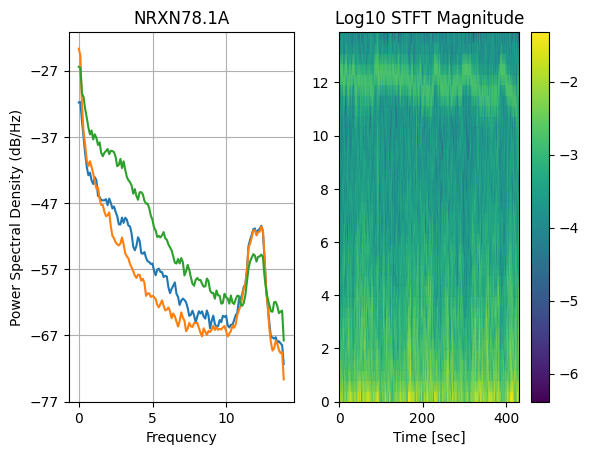

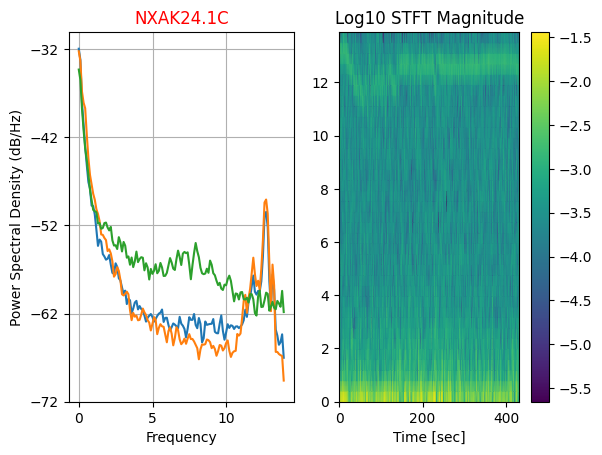

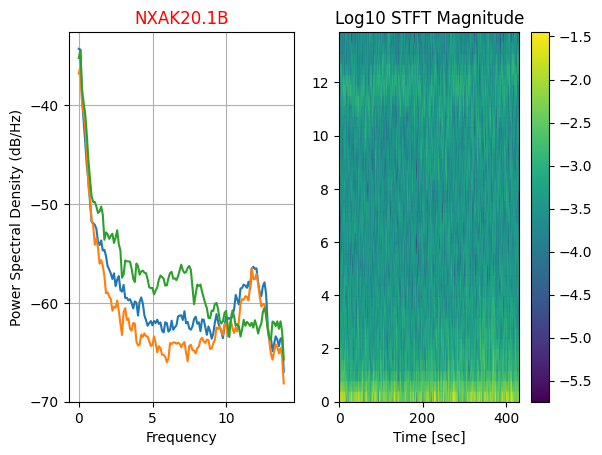

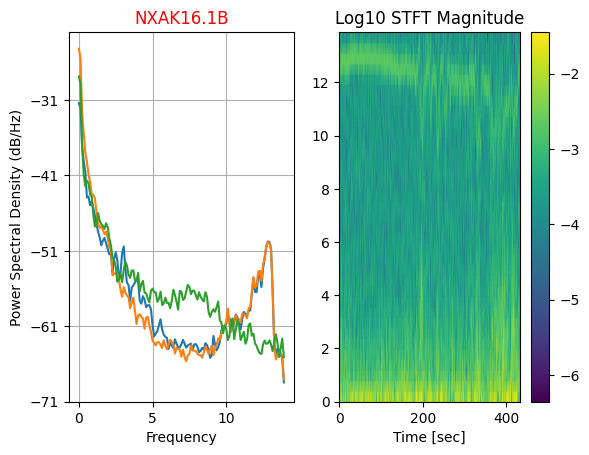

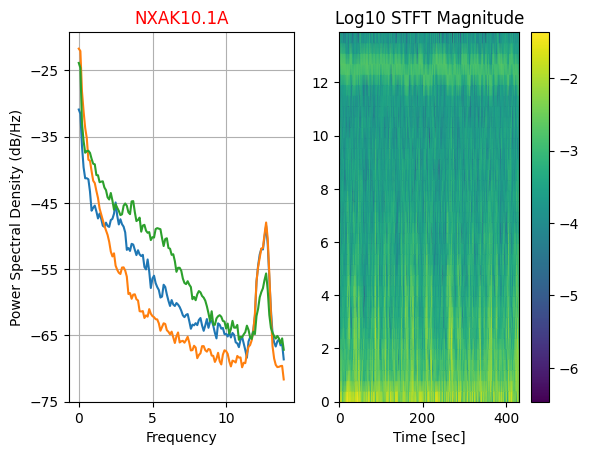

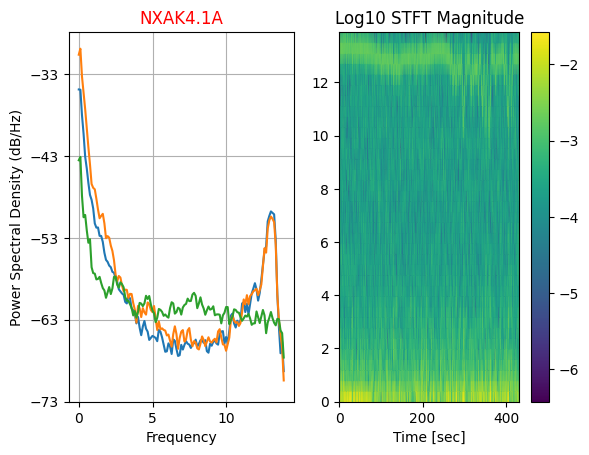

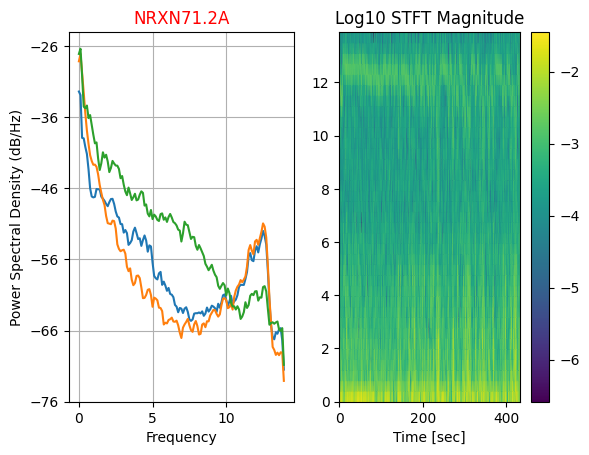

In [6]:
names = ["NXAK22.1A","NXAK14.1A","NXAK7.1B","NXAK4.1B","NRXN78.1D","NRXN78.1A"]
names_knock = ["NXAK24.1C","NXAK20.1B","NXAK16.1B","NXAK10.1A","NXAK4.1A","NRXN71.2A"]

for name in names+names_knock:

    base_directory = r"/home/k21208334/calcium_analyses/data/" + name + "/"
    sample = widefield_utils.get_delta_f_sample_from_svd_unprocessed(base_directory,0,12000)

    fig,ax = plt.pyplot.subplots(1,2)
    ax[0].psd(sample[115,115,:], Fs=1/Ts);
    ax[0].psd(sample[225,75,:], Fs=1/Ts);
    ax[0].psd(sample[38,150,:], Fs=1/Ts);
    ax[0].set_title(name)
    if name in names_knock:
        ax[0].set_title(name,color='red')

    F, t, Zxx = signal.stft(sample[115,115,:], fs=1/Ts, window='hann', nperseg=70)
    ax[1].pcolormesh(t, F, np.log10(abs(Zxx)),shading='gouraud')
    ax[1].set_title('Log10 STFT Magnitude')
    ax[1].set_xlabel('Time [sec]')

    a = plt.cm.ScalarMappable()
    a.set_clim(vmin=np.log10(abs(Zxx)).min(), vmax=np.log10(abs(Zxx)).max())
    fig.colorbar(a, ax=ax[1])


In [12]:
np.savez_compressed('signals_8k.npy', **signals_dict) # started 15.15

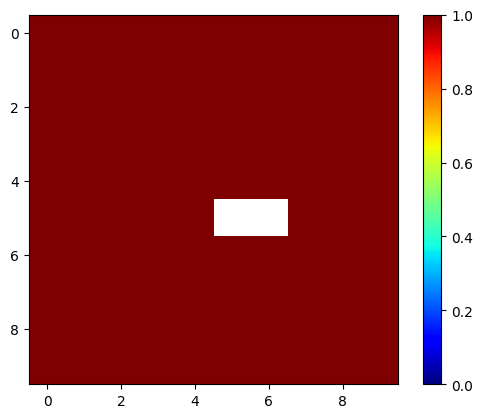

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a random matrix for demonstration
matrix = np.ones((10,10))
matrix[5,5] = 0
matrix[5,6] = 0

# Set zero elements to white color
masked_matrix = np.ma.masked_where(matrix == 0, matrix)

# Plot the masked matrix with a colorscale
plt.imshow(masked_matrix, cmap='jet', vmin=matrix.min(), vmax=matrix.max())
plt.colorbar()

# Set white color for zero elements
#plt.imshow(matrix == 0, cmap='binary')

# Show the plot
plt.show()